In [1]:
from tqdm import tqdm
from util.workflow import *
from util.reader import *
from util.bp_util import *
from util.plot import *
get_ipython().run_line_magic("matplotlib", "inline")

## Config

In [2]:
# dataset config
config = read_das_config("./config.yaml")
systems = config.keys()
# from tap test
ichanN = config["north"]["dasinfo"].ichan.values
ichanS = config["south"]["dasinfo"].ichan.values
# ncedc catalog
catalog = read_catalog("./Data/catalog.csv")
catalog = prepare_catalog_window(catalog, time_before=5, time_after=50)
catalog_bp_1_5 = catalog.iloc[[0, 1]].reset_index(drop=True)
catalog_bp_4_8 = catalog.iloc[[0, 2]].reset_index(drop=True)
mainshock = catalog.iloc[0].to_dict()
aftershock_egf1 = catalog.iloc[1].to_dict()
aftershock_egf2 = catalog.iloc[2].to_dict()
# finite fault product
fn_param = "./Data/products/basic_inversion.param"
fn_mr_usgs = "./Data/products/moment_rate.mr"
fn_mr_scardec = "./Data/products/fctmoyselect_Nm.txt"
ff_dict = get_finite_fault_query(fn_param)

## Preprocess

In [3]:
## BP 1-5 Hz
path_processed_bp = "./Data/DASDataProcessed/bp_1_5"
freqmin = 1.0
freqmax = 5.0
# run_preprocess_workflow(
#     mainshock, aftershock_egf1, freqmin, freqmax, path_processed_bp, config
# )
## BP 4-8 Hz
path_processed_bp = "./Data/DASDataProcessed/bp_4_8"
freqmin = 4.0
freqmax = 8.0
# run_preprocess_workflow(
#     mainshock, aftershock_egf2, freqmin, freqmax, path_processed_bp, config
# )

Processing data...: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


## Back-projection

In [4]:
## subevents 1-3
event_id = "nc73584926"
egf_id = "nc73585056"
path_processed_bp = "./Data/DASDataProcessed/bp_1_5"

bp_data_dict, bp_image_dict, bp_image = run_bp_workflow(
    event_id, egf_id, path_processed_bp, config
)
# joint location with finite-fault
check_gt_max = [
    {"ig": 12872, "it": 668},
    {"ig": 12019, "it": 942},
    {"ig": 7993, "it": 1303},
]
subevent_list = []
for gt in tqdm(check_gt_max):
    subevent = get_joint_location_time(
        bp_image["ccPS"],
        gt["it"],
        bp_image["grid_info"],
        ff_dict,
    )
    subevent_list.append(subevent)

BP done, start postprocessing
BP done, start postprocessing


100%|██████████| 3/3 [01:19<00:00, 26.66s/it]


In [5]:
## subevent 0
event_id = "nc73584926"
egf_id = "nc73585086"
path_processed_bp = "./Data/DASDataProcessed/bp_4_8"
bp_data_dict0, bp_image_dict0, bp_image0 = run_bp_workflow(
    event_id, egf_id, path_processed_bp, config
)
# joint location with finite-fault
check_gt_max = [
    {"ig": 13552, "it": 607},
]
subevent_list0 = []
for gt in tqdm(check_gt_max):
    subevent0 = get_joint_location_time(
        bp_image0["ccPS"],
        gt["it"],
        bp_image0["grid_info"],
        ff_dict,
        mask_threshold=0.7,
    )
    subevent_list0.append(subevent0)

BP done, start postprocessing
BP done, start postprocessing


100%|██████████| 1/1 [00:18<00:00, 18.32s/it]


In [6]:
colors = ["tab:blue", "tab:green", "tab:purple", "tab:red"]
subevent_list_all = subevent_list0 + subevent_list
for i, subevt in enumerate(subevent_list_all):
    subevt["color"] = colors[i]

## Visualization

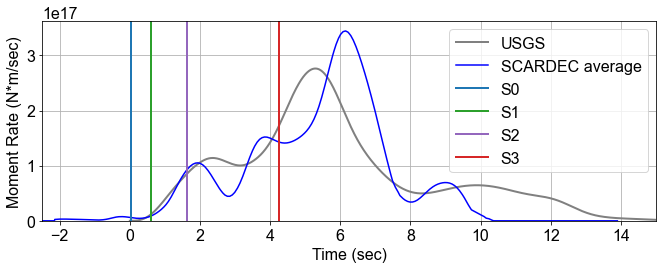

In [7]:
# time w.r.t. moment rate function
fig, ax = plot_subevent_stf(subevent_list_all, fn_mr_usgs, fn_mr_scardec)

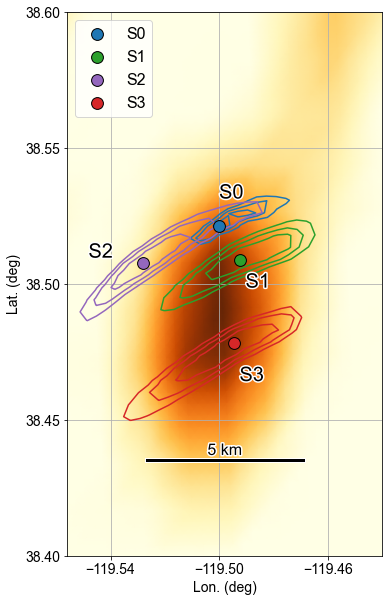

In [8]:
# location w.r.t. finite-fault solution
fig, ax = plot_subevent_contour_on_finite_fault_mapview(ff_dict, subevent_list_all)

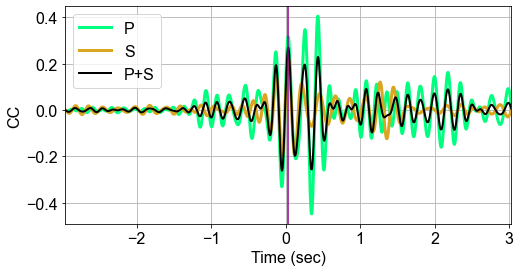

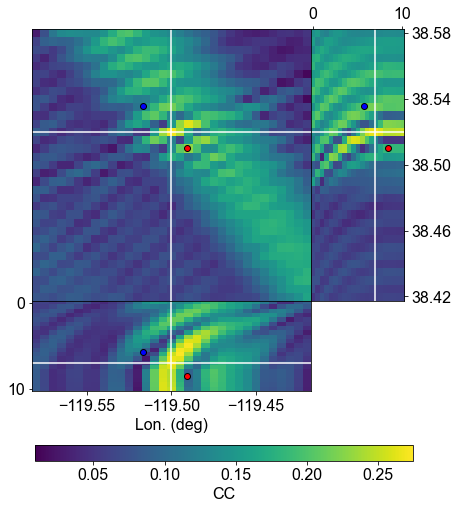

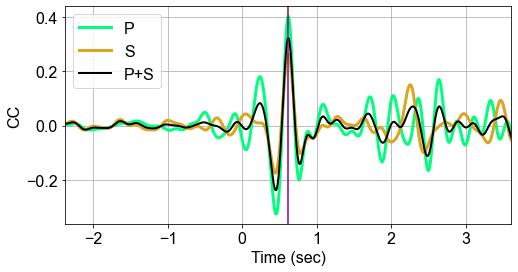

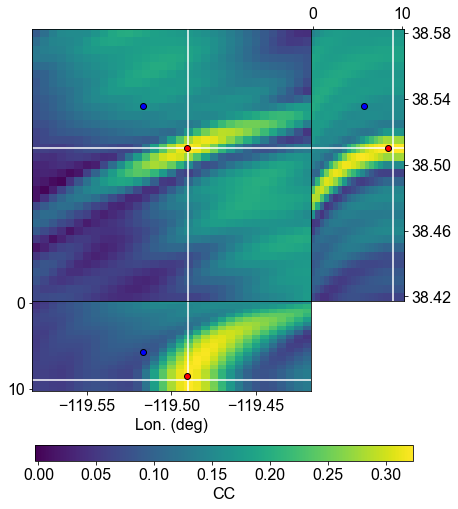

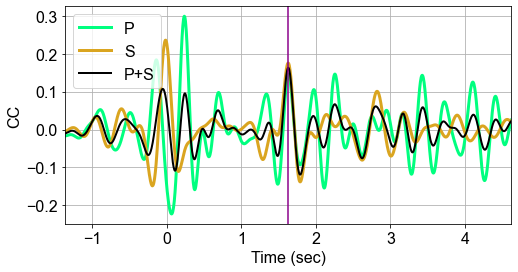

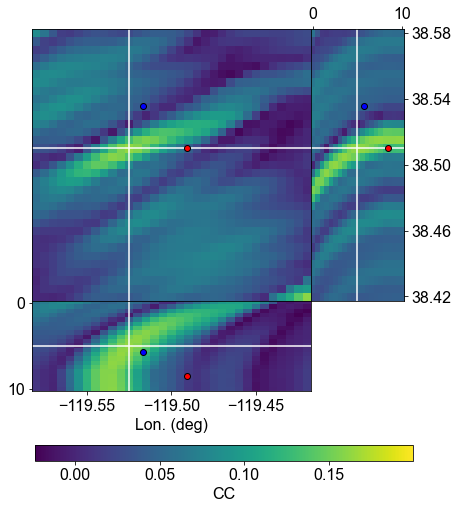

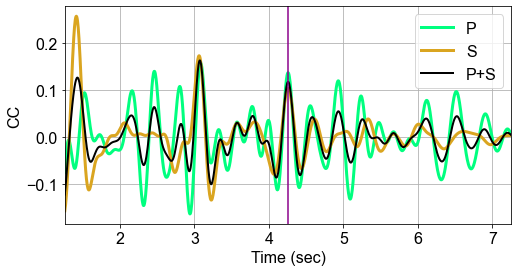

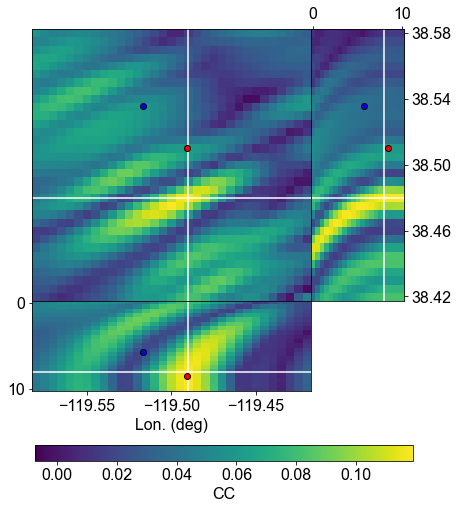

In [9]:
# 3D slice and 1d time series
slice_xticks = [-119.55, -119.50, -119.45]
slice_yticks = [38.42, 38.46, 38.5, 38.54, 38.58]
for i, subevent in enumerate(subevent_list_all):
    if i == 0:
        bp_show = bp_image0
    else:
        bp_show = bp_image
    fig, ax = plot_cc1d_res(
        bp_show["ccP"], bp_show["ccS"], bp_show["ccPS"], subevent
    )
    fig, ax = show_cc_mat(
        subevent["cmat"],
        bp_show["grid_info"],
        event=mainshock,
        event_egf=aftershock_egf1,
        center=[subevent["lon_g"], subevent["lat_g"], subevent["dep_g"]],
        figsize=(7.5, 7.5),
    )
    ax[1].set_xticks(slice_xticks)
    ax[2].set_yticks(slice_yticks)
    ax[1].set_xlabel("Lon. (deg)")

## Interactive GUI

In [ ]:
from util.gui import vis_bp_xyzt
get_ipython().run_line_magic("matplotlib", "widget")
vis = vis_bp_xyzt(
    bp_image["ccPS"],
    bp_image["ccP"],
    bp_image["ccS"],
    bp_image["grid_info"],
    event=mainshock,
    event_egf=aftershock_egf1,
)
vis